In [5]:
import os
import cv2
import re
import torch
import numpy as np
import kornia as K
import kornia.feature as KF
from SuperGluePretrainedNetwork.models.matching import Matching

from build_pointcloud import build_pointcloud
from transform import build_se3_transform
from image import load_image
from camera_model import CameraModel

import open3d as o3d
import pyscancontext as sc

import numpy as np

In [44]:
def load_torch_image(img, device=torch.device('cpu')):
    img = K.image_to_tensor(img, False).float() / 255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

def load_superglue(device=torch.device('cpu')):

    config = {
        'superpoint': {
            'nms_radius': 3,
            'keypoint_threshold': 0.005,
            'max_keypoints': 2048
        },
        'superglue': {
            'weights': 'outdoor',
            'sinkhorn_iterations': 20,
            'match_threshold': 0.2,
        }
    }
    s_s = Matching(config).eval().to(device)

    return s_s
    

def superglue_matching(query_img, ref_img, worker = load_superglue(device=torch.device('cuda'))):

    query_tensor = K.color.rgb_to_grayscale(load_torch_image(query_img, device=torch.device('cuda')))
    ref_tensor = K.color.rgb_to_grayscale(load_torch_image(ref_img, device=torch.device('cuda')))

    input_dict = {"image0": query_tensor, "image1": ref_tensor}

    pred = worker(input_dict)
    pred = {k: v[0].cpu().detach().numpy() for k, v in pred.items()}
    kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
    matches0, matches1 = pred['matches0'], pred['matches1']

    valid0 = matches0 > -1
    valid1 = matches1 > -1
    mkpts0 = np.int32(kpts0[valid0])
    mkpts1 = np.int32(kpts1[valid1])

    return mkpts0, mkpts1

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [12]:
fx = 964.828979   
cx = 964.828979
fy = 643.788025
cy = 484.407990


In [57]:
import numpy as np
from scipy.spatial.transform import Rotation as R

pose_vo = """
1418756796412531,1418756796350039,5.245050e-01,-2.687204e-03,-2.685869e-02,-3.724400e-03,-1.380256e-03,5.048370e-03
1418756796475023,1418756796412531,5.379963e-01,6.027592e-03,-2.627966e-02,-3.222082e-03,-2.762420e-03,4.245534e-03
1418756796537514,1418756796475023,5.460759e-01,6.981143e-03,-2.777983e-02,-2.253349e-03,-3.557852e-03,3.878982e-03
1418756796600006,1418756796537514,5.395860e-01,7.598860e-03,-2.639325e-02,-4.860662e-04,-3.590046e-03,3.794598e-03
1418756796662498,1418756796600006,5.004656e-01,5.179815e-03,-2.815260e-02,8.834213e-04,-3.217865e-03,3.943285e-03
1418756796724989,1418756796662498,5.204499e-01,1.117157e-02,-2.797434e-02,1.770949e-04,-1.132303e-03,4.426768e-03
1418756796787481,1418756796724989,5.265476e-01,9.950774e-03,-2.607536e-02,-1.448659e-03,9.828907e-04,4.411844e-03
1418756796849973,1418756796787481,5.383687e-01,6.534395e-03,-3.278367e-02,-1.184476e-03,2.470852e-03,4.547905e-03
1418756796912464,1418756796849973,5.312280e-01,9.326241e-03,-2.865984e-02,-4.839180e-04,3.059163e-03,4.338966e-03
"""

# 假设你已经有了位姿数据，按照顺序存放在列表中
pose_data = [
    # [x, y, z, roll, pitch, yaw]
    # 数据从1418756796350039到1418756796912464的位姿信息
]
    
for line in pose_vo.strip().split("\n"):
    parts = line.split(",")
    # 从第三个元素开始取，因为前两个元素是时间戳
    pose = [float(part) for part in parts[2:]]
    pose_data.append(pose)

# 初始化一个单位变换矩阵
total_transform = np.eye(4)

# 对于每一个位姿数据
for pose in pose_data:
    x, y, z, roll, pitch, yaw = pose

    # 创建一个旋转矩阵
    rotation = R.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

    # 创建一个变换矩阵
    transform = np.eye(4)
    transform[:3, :3] = rotation
    transform[:3, 3] = [x, y, z]

    # 将新的变换矩阵与总变换矩阵相乘，得到新的总变换矩阵
    total_transform = total_transform @ transform

print(total_transform)

[[ 0.99921313 -0.038558   -0.00929572  4.76502259]
 [ 0.03866603  0.99918327  0.01173583  0.14026348]
 [ 0.00883561 -0.01208603  0.99988792 -0.20897372]
 [ 0.          0.          0.          1.        ]]


In [59]:
import numpy as np


cameraMatrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

query_img = cv2.imread("./test/1418756796350039.jpg")
ref_img = cv2.imread("./test/1418756796912464.jpg")

mkpts0, mkpts1 = superglue_matching(query_img, ref_img)



R = total_transform[:3, :3]
t = total_transform[:3, 3]
t = t.reshape(-1, 1)
Rt2 = np.hstack([R, t])
P1 = np.hstack((cameraMatrix, np.zeros((3, 1))))
P2 = np.dot(cameraMatrix, Rt2)

points4D = cv2.triangulatePoints(P1, P2, np.float32(mkpts0.T), np.float32(mkpts1.T))

points3D = points4D / np.repeat(points4D[3, :], 4).reshape(4, -1)


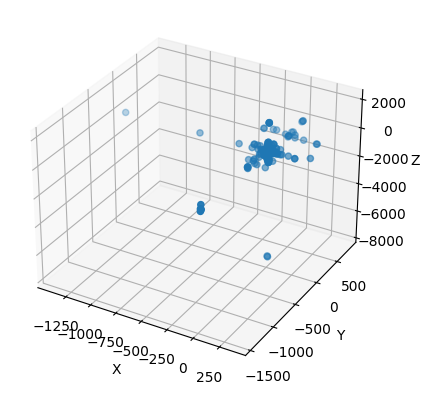

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[0, :], points[1, :], points[2, :])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# 将齐次坐标转换为笛卡尔坐标（去除尺度因子）
points3D = points3D[:3, :]

plot_3d(points3D)

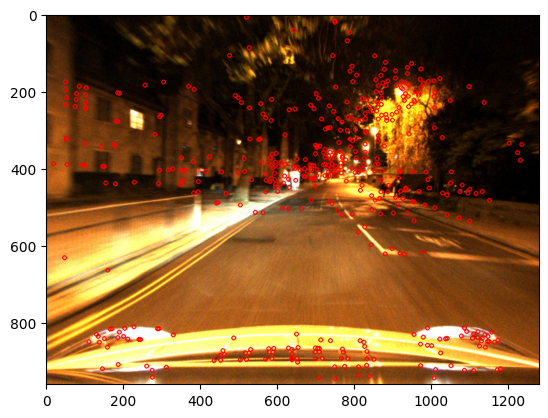

In [61]:
# 创建一个复制的图像，以便我们可以在上面绘制圈圈而不影响原始图像
query_img_copy = query_img.copy()

# 对每个关键点进行迭代，绘制一个圆圈
for pt in mkpts1:
    # OpenCV的circle函数需要整数坐标，所以我们使用astype将坐标转换为整数
    pt = pt.astype(int)

    # 在关键点的位置绘制一个红色的圆圈，半径为5像素，线宽为2像素
    cv2.circle(query_img_copy, tuple(pt), 5, (0, 0, 255), 2)

# 使用matplotlib显示图像
plt.imshow(cv2.cvtColor(query_img_copy, cv2.COLOR_BGR2RGB))
plt.show()